In [73]:
import os
import os.path
import glob
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve
from sklearn import svm

import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'Paired'

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input

In [2]:
imagedir = "Dataset_4850"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.jpg'))  # assuming the images are stored as 'jpg'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.jpg'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:              CG	Number of images: 4850
Label: 1	Family:              PG	Number of images: 4850
Processing images ...
Images processed: 9700


In [4]:
X.shape

(9700, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
filename = 'paper-resnet50features-avgpool.npy'
if os.path.exists(filename):
    print("Loading ResNet50 extracted features from %s ..." %(filename))
    resnet50features = np.load(filename)
else:
    print("Extracting features from ResNet50 layers ...")
    resnet50features = base_model.predict(X)
    print("Saving ResNet50 extracted features into %s ..." %(filename))
    np.save(filename, resnet50features)

Loading ResNet50 extracted features from paper-resnet50features-avgpool.npy ...


In [ ]:
resnet50features.shape

(9700, 2048)

In [ ]:
# Training top_model
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv, verbose=10, n_jobs=-1)
top_model.fit(resnet50features,y)  # Training 

Fitting 5 folds for each of 169 candidates, totalling 845 fits
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, g

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 13.4min


[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-09, score=0.791237, total= 7.7min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.801546, total= 7.7min
[CV] .............. C=0.01, gamma=1e-09, score=0.779381, total= 7.7min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-09, score=0.798454, total= 7.8min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.779381, total= 7.8min
[CV] .............. C=0.01, gamma=1e-07, score=0.790722, total= 7.8min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-09, score=0.799485, total= 7.8min
[CV] C=0.01, gamma=0.001 .............................................
[CV] C

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 17.4min


[CV] .............. C=0.01, gamma=1e-06, score=0.797938, total= 9.4min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.797938, total=10.0min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.799485, total=10.0min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.791237, total=10.0min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.799485, total=10.0min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.778866, total=10.0min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.802062, total=10.0min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 18.8min


[CV] .............. C=0.01, gamma=0.001, score=0.818041, total= 6.6min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.827320, total= 6.6min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.809794, total= 6.6min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.830928, total= 6.6min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.839175, total= 6.6min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.787629, total= 7.1min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.807216, total= 7.1min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 37.2min


[CV] ............... C=0.01, gamma=0.01, score=0.607732, total=11.1min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ................ C=0.01, gamma=1.0, score=0.668041, total= 7.0min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ............... C=0.01, gamma=10.0, score=0.506186, total= 7.0min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ................ C=0.01, gamma=1.0, score=0.675773, total= 7.0min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ............... C=0.01, gamma=10.0, score=0.507216, total= 7.0min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.508247, total= 7.1min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.728351, total=11.1min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 38.3min


[CV] ................ C=0.01, gamma=1.0, score=0.675773, total=11.1min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.657216, total=11.1min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.537629, total=11.1min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.507216, total= 7.0min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] .............. C=0.01, gamma=100.0, score=0.504639, total= 7.0min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] .............. C=0.01, gamma=100.0, score=0.505670, total= 7.0min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] .............. C=0.01, gamma=100.0, score=0.505155, total= 7.0min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 50.7min


[CV] ............... C=0.1, gamma=1e-07, score=0.801546, total= 7.1min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.778866, total= 7.1min
[CV] ............... C=0.1, gamma=1e-07, score=0.790722, total= 7.1min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.797938, total= 7.1min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.790722, total= 7.1min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.801546, total= 7.1min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.799485, total= 7.1min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 57.9min


[CV] ............... C=0.1, gamma=1e-08, score=0.779381, total=11.0min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.797938, total=11.0min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-08, score=0.801546, total=11.1min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-07, score=0.799485, total=11.1min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.896392, total= 4.1min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=0.0001, score=0.871649, total= 4.8min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=0.0001, score=0.869588, total= 4.7min
[CV] C=0.1, gamma=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 68.1min


[CV] ............... C=0.1, gamma=0.001, score=0.904124, total= 6.5min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ............... C=0.1, gamma=0.001, score=0.900000, total= 6.4min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ............... C=0.1, gamma=0.001, score=0.896392, total= 6.4min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.542268, total= 7.0min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ................. C=0.1, gamma=1.0, score=0.670103, total= 6.9min
[CV] C=0.1, gamma=1000.0 .............................................
[CV] ................. C=0.1, gamma=1.0, score=0.675258, total= 6.9min
[CV] C=0.1, gamma=1000.0 .............................................
[CV] ................. C=0.1, gamma=1.0, score=0.659278, total= 6.9min
[CV] C=0.1, gamma=1000.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 77.4min


[CV] ................ C=0.1, gamma=0.01, score=0.728351, total=10.9min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.612887, total=10.9min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.675258, total=10.9min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.533505, total=10.9min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.542784, total=10.9min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.541237, total=10.9min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ............... C=0.1, gamma=100.0, score=0.508247, total= 6.9min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 88.5min


[CV] ............... C=0.1, gamma=100.0, score=0.504124, total=10.9min
[CV] ............... C=0.1, gamma=100.0, score=0.505670, total=10.8min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.797938, total= 7.0min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.909278, total= 2.8min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.913918, total= 2.8min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.914948, total= 2.8min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.873711, total= 4.6min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 97.2min


[CV] ............... C=1.0, gamma=1e-07, score=0.790722, total=10.9min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-06, score=0.801031, total= 6.8min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-06, score=0.809794, total= 6.8min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-06, score=0.798454, total= 6.8min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-06, score=0.792268, total= 6.8min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.812371, total= 6.9min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ............... C=1.0, gamma=0.001, score=0.935052, total= 2.9min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 111.7min


[CV] ................ C=1.0, gamma=10.0, score=0.505670, total= 8.3min
[CV] C=10.0, gamma=1e-09 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.504124, total= 8.2min
[CV] C=10.0, gamma=1e-09 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.508247, total= 8.3min
[CV] C=10.0, gamma=1e-09 .............................................
[CV] ............... C=1.0, gamma=100.0, score=0.505670, total= 8.2min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.506701, total=12.6min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.506186, total=12.7min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.507732, total=12.7min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 125.3min


[CV] .............. C=10.0, gamma=1e-09, score=0.802062, total= 7.1min
[CV] C=10.0, gamma=1e-05 .............................................
[CV] .............. C=1.0, gamma=1000.0, score=0.504124, total= 8.3min
[CV] C=10.0, gamma=1e-05 .............................................
[CV] .............. C=10.0, gamma=1e-09, score=0.791237, total= 7.1min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=1.0, gamma=1000.0, score=0.508247, total= 8.3min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] ............... C=1.0, gamma=100.0, score=0.504124, total=12.6min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-09, score=0.779381, total= 7.1min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.797938, total= 6.9min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 134.7min


[CV] .............. C=10.0, gamma=0.001, score=0.940722, total= 3.2min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] .............. C=10.0, gamma=0.001, score=0.941753, total= 3.2min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] .............. C=10.0, gamma=0.001, score=0.942268, total= 3.2min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] .............. C=10.0, gamma=0.001, score=0.938660, total= 3.2min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.799485, total=10.9min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.801031, total=10.7min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.801546, total=10.9min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 152.9min


[CV] ................ C=10.0, gamma=1.0, score=0.505670, total=12.4min
[CV] C=100.0, gamma=1e-09 ............................................
[CV] ................ C=10.0, gamma=1.0, score=0.504124, total=12.9min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............... C=10.0, gamma=0.01, score=0.720103, total=16.2min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............. C=100.0, gamma=1e-09, score=0.798454, total= 7.0min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ................ C=10.0, gamma=0.1, score=0.506186, total=19.5min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ................ C=10.0, gamma=1.0, score=0.504639, total=19.1min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=100.0, score=0.508247, total=10.5min
[CV] C=100.0, gamma=1e-07 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 167.5min


[CV] .............. C=10.0, gamma=100.0, score=0.504124, total=20.2min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............. C=100.0, gamma=1e-05, score=0.923711, total= 2.0min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.927835, total= 1.9min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.928866, total= 2.0min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.910309, total= 2.8min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.927835, total= 2.0min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.914948, total= 2.8min
[CV] C=100.0, gamma=0.01 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 175.4min


[CV] ............. C=100.0, gamma=1e-07, score=0.873711, total= 7.1min
[CV] ............. C=100.0, gamma=0.001, score=0.942268, total= 3.2min
[CV] C=100.0, gamma=10.0 .............................................
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............. C=100.0, gamma=0.001, score=0.938660, total= 3.2min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.798454, total=10.7min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.791753, total=10.6min
[CV] C=100.0, gamma=100.0 ............................................
[CV] .............. C=100.0, gamma=0.01, score=0.709794, total=10.3min
[CV] C=100.0, gamma=100.0 ............................................
[CV] .............. C=100.0, gamma=0.01, score=0.709794, total=10.6min
[CV] C=100.0, gamma=1000.0 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed: 202.2min


[CV] ............. C=100.0, gamma=100.0, score=0.508247, total=10.4min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.505155, total=19.5min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-09, score=0.801546, total= 6.9min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=100.0, gamma=1000.0, score=0.504639, total=12.1min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-09, score=0.809794, total= 6.9min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-06, score=0.921649, total= 1.9min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=100.0, gamma=1000.0, score=0.505155, total=12.6min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed: 209.0min


[CV] ............ C=1000.0, gamma=1e-08, score=0.884536, total= 7.1min
[CV] C=1000.0, gamma=0.1 .............................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.912371, total= 4.2min
[CV] C=1000.0, gamma=0.1 .............................................
[CV] ............. C=100.0, gamma=100.0, score=0.505670, total=19.4min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.869072, total= 7.1min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] ........... C=1000.0, gamma=0.0001, score=0.926804, total= 2.0min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] ........... C=1000.0, gamma=0.0001, score=0.931443, total= 2.0min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] ............. C=100.0, gamma=100.0, score=0.504124, total=19.8min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed: 233.7min


[CV] ............. C=1000.0, gamma=0.01, score=0.700515, total=16.5min
[CV] C=10000.0, gamma=1e-08 ..........................................
[CV] ............. C=1000.0, gamma=0.01, score=0.715464, total=16.7min
[CV] C=10000.0, gamma=1e-08 ..........................................
[CV] .............. C=1000.0, gamma=0.1, score=0.506701, total=16.8min
[CV] C=10000.0, gamma=1e-08 ..........................................
[CV] .............. C=1000.0, gamma=1.0, score=0.508247, total=16.3min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] ........... C=10000.0, gamma=1e-09, score=0.868557, total= 4.6min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] ........... C=10000.0, gamma=1e-08, score=0.910309, total= 2.7min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] ........... C=10000.0, gamma=1e-09, score=0.873711, total= 4.6min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 241.8min


[CV] ........... C=10000.0, gamma=1e-05, score=0.906701, total= 1.7min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] ........... C=10000.0, gamma=1e-05, score=0.909278, total= 2.6min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] ........... C=1000.0, gamma=1000.0, score=0.504639, total=12.1min
[CV] ........... C=10000.0, gamma=1e-05, score=0.914433, total= 1.7min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] ........... C=10000.0, gamma=1e-05, score=0.905670, total= 1.7min
[CV] C=10000.0, gamma=0.1 ............................................
[CV] ........... C=10000.0, gamma=1e-05, score=0.903093, total= 1.8min
[CV] C=10000.0, gamma=0.1 ............................................
[CV] ........... C=1000.0, gamma=1000.0, score=0.505155, total=12.5min
[CV] C=10000.0, gamma=0.1 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 433 tasks      | elapsed: 261.8min


[CV] ............. C=10000.0, gamma=0.1, score=0.506186, total=12.6min
[CV] C=100000.0, gamma=1e-09 .........................................
[CV] ............. C=10000.0, gamma=1.0, score=0.505155, total=12.5min
[CV] C=100000.0, gamma=1e-09 .........................................
[CV] ............. C=10000.0, gamma=1.0, score=0.505670, total=12.6min
[CV] C=100000.0, gamma=1e-09 .........................................
[CV] ............. C=10000.0, gamma=1.0, score=0.504124, total=13.0min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] .......... C=100000.0, gamma=1e-09, score=0.910309, total= 2.7min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] .......... C=100000.0, gamma=1e-08, score=0.924227, total= 1.9min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] .......... C=100000.0, gamma=1e-09, score=0.913918, total= 2.8min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed: 273.6min


[CV] .......... C=100000.0, gamma=1e-05, score=0.906701, total= 1.9min
[CV] C=100000.0, gamma=0.001 .........................................
[CV] ............ C=10000.0, gamma=10.0, score=0.504124, total=19.9min
[CV] C=100000.0, gamma=0.001 .........................................
[CV] ............ C=10000.0, gamma=10.0, score=0.508247, total=16.3min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] ........... C=10000.0, gamma=100.0, score=0.508247, total=10.5min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] .......... C=100000.0, gamma=1e-05, score=0.914433, total= 2.7min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] ......... C=100000.0, gamma=0.0001, score=0.926804, total= 2.0min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] .......... C=100000.0, gamma=1e-05, score=0.905670, total= 2.6min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 497 tasks      | elapsed: 295.7min


[CV] ........... C=100000.0, gamma=10.0, score=0.508247, total=10.8min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ........... C=100000.0, gamma=10.0, score=0.504639, total=12.4min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ............ C=100000.0, gamma=1.0, score=0.505670, total=12.9min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ........... C=100000.0, gamma=10.0, score=0.505670, total=12.8min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] .......... C=100000.0, gamma=100.0, score=0.504639, total=12.4min
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] ......... C=1000000.0, gamma=1e-09, score=0.918041, total= 1.9min
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] ......... C=1000000.0, gamma=1e-09, score=0.929381, total= 1.9min
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed: 305.8min


[CV] ......... C=1000000.0, gamma=1e-05, score=0.906701, total= 1.9min
[CV] C=1000000.0, gamma=0.001 ........................................
[CV] ........... C=100000.0, gamma=10.0, score=0.504124, total=19.4min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ......... C=1000000.0, gamma=1e-05, score=0.909278, total= 2.6min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ......... C=1000000.0, gamma=1e-05, score=0.903093, total= 1.9min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ......... C=1000000.0, gamma=1e-05, score=0.914433, total= 2.7min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ........ C=1000000.0, gamma=0.0001, score=0.931443, total= 2.1min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ........ C=1000000.0, gamma=0.0001, score=0.924742, total= 2.1min
[CV] C=1000000.0, gamma=0.1 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 565 tasks      | elapsed: 329.6min


[CV] .......... C=1000000.0, gamma=0.01, score=0.720103, total=15.4min
[CV] C=10000000.0, gamma=1e-09 .......................................
[CV] .......... C=1000000.0, gamma=10.0, score=0.505670, total=12.6min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ......... C=1000000.0, gamma=100.0, score=0.504639, total=12.0min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ........... C=1000000.0, gamma=0.1, score=0.507732, total=15.7min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] .......... C=1000000.0, gamma=10.0, score=0.504124, total=12.8min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ........... C=1000000.0, gamma=0.1, score=0.509794, total=14.7min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ......... C=1000000.0, gamma=100.0, score=0.505155, total=12.5min
[CV] C=10000000.0, gamma=1e-07 .......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed: 336.5min


[CV] ........ C=10000000.0, gamma=1e-05, score=0.906701, total= 2.0min
[CV] C=10000000.0, gamma=0.01 ........................................
[CV] ........ C=10000000.0, gamma=1e-05, score=0.914433, total= 2.0min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ........ C=10000000.0, gamma=1e-05, score=0.903093, total= 2.1min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ......... C=1000000.0, gamma=100.0, score=0.504124, total=16.0min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ....... C=10000000.0, gamma=0.0001, score=0.926804, total= 2.3min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ....... C=10000000.0, gamma=0.0001, score=0.927835, total= 2.2min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ....... C=10000000.0, gamma=0.0001, score=0.931443, total= 2.4min
[CV] C=10000000.0, gamma=1.0 .........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 637 tasks      | elapsed: 358.2min


[CV] .......... C=10000000.0, gamma=1.0, score=0.504124, total=12.9min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ......... C=10000000.0, gamma=10.0, score=0.508247, total=10.5min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ....... C=100000000.0, gamma=1e-09, score=0.918041, total= 1.7min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ....... C=100000000.0, gamma=1e-09, score=0.915464, total= 1.6min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ......... C=10000000.0, gamma=10.0, score=0.504639, total=12.1min
[CV] C=100000000.0, gamma=1e-06 ......................................
[CV] ......... C=10000000.0, gamma=10.0, score=0.505155, total=12.5min
[CV] C=100000000.0, gamma=1e-06 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.886082, total= 2.4min
[CV] C=100000000.0, gamma=1e-06 ......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed: 365.8min


[CV] ....... C=100000000.0, gamma=0.001, score=0.944845, total= 3.6min
[CV] C=100000000.0, gamma=1.0 ........................................
[CV] ....... C=100000000.0, gamma=0.001, score=0.940722, total= 3.6min
[CV] C=100000000.0, gamma=1.0 ........................................
[CV] ....... C=100000000.0, gamma=0.001, score=0.941753, total= 3.4min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ....... C=100000000.0, gamma=0.001, score=0.942268, total= 3.4min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ........ C=10000000.0, gamma=100.0, score=0.508247, total=10.4min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ....... C=100000000.0, gamma=0.001, score=0.938660, total= 3.4min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ....... C=10000000.0, gamma=1000.0, score=0.504639, total=12.2min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 713 tasks      | elapsed: 388.4min


[CV] ...... C=1000000000.0, gamma=1e-07, score=0.895876, total= 1.8min
[CV] C=1000000000.0, gamma=1e-05 .....................................
[CV] ...... C=1000000000.0, gamma=1e-07, score=0.897938, total= 1.8min
[CV] C=1000000000.0, gamma=1e-05 .....................................
[CV] ...... C=1000000000.0, gamma=1e-07, score=0.907732, total= 1.8min
[CV] C=1000000000.0, gamma=1e-05 .....................................
[CV] ...... C=1000000000.0, gamma=1e-07, score=0.894330, total= 1.8min
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] ...... C=1000000000.0, gamma=1e-07, score=0.898969, total= 1.7min
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] ........ C=100000000.0, gamma=10.0, score=0.504124, total=13.6min
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] ...... C=1000000000.0, gamma=1e-06, score=0.902062, total= 1.8min
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed: 408.3min


[CV] ........ C=1000000000.0, gamma=0.1, score=0.507732, total=10.8min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ........ C=1000000000.0, gamma=0.1, score=0.506186, total=10.9min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ....... C=1000000000.0, gamma=0.01, score=0.709794, total=11.4min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ....... C=1000000000.0, gamma=0.01, score=0.720103, total=11.5min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ....... C=1000000000.0, gamma=0.01, score=0.715464, total=12.0min
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] ........ C=1000000000.0, gamma=0.1, score=0.506701, total=12.1min
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] ........ C=1000000000.0, gamma=0.1, score=0.506186, total=12.5min
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 793 tasks      | elapsed: 420.4min


[CV] ..... C=10000000000.0, gamma=1e-06, score=0.895361, total= 2.3min
[CV] C=10000000000.0, gamma=0.01 .....................................
[CV] ..... C=10000000000.0, gamma=1e-05, score=0.914433, total= 1.8min
[CV] C=10000000000.0, gamma=0.01 .....................................
[CV] ..... C=10000000000.0, gamma=1e-05, score=0.905670, total= 1.8min
[CV] C=10000000000.0, gamma=0.01 .....................................
[CV] ..... C=10000000000.0, gamma=1e-05, score=0.903093, total= 1.8min
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] .... C=10000000000.0, gamma=0.0001, score=0.927835, total= 2.2min
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] .... C=10000000000.0, gamma=0.0001, score=0.926804, total= 2.6min
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] .... C=10000000000.0, gamma=0.0001, score=0.931443, total= 2.6min
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] .

In [18]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 10.0, 'gamma': 0.001} - score: 0.9416


In [19]:
top_model.cv_results_

{'mean_fit_time': array([  386.58294835,   432.8404211 ,   414.93337474,   427.47926197,
          429.6210659 ,   344.29098039,   319.14934516,   498.87183557,
          538.61397109,   457.48626437,   338.60484915,   339.02313867,
          412.90268383,   456.52374091,   534.2744288 ,   419.3643322 ,
          342.75315537,   333.99067979,   230.44799004,   287.72201519,
          523.97338862,   449.36613822,   334.54900646,   336.93360572,
          481.88335185,   334.03662114,   337.79098802,   487.36088481,
          489.08954277,   328.77871633,   270.8526906 ,   167.36658983,
          157.99483147,   649.81016064,   586.91029954,   503.44190931,
          414.18724756,   545.38668895,   414.52318621,   341.97273846,
          490.7578166 ,   516.15382991,   270.89682755,   133.601653  ,
          108.93793507,   154.58120813,   607.17175283,   655.54899807,
          716.43742619,  1002.81586089,   944.23331504,   641.78917017,
          339.5721724 ,   438.38419981,   243.2

In [20]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    
    ax.set_xscale('log')
    #ax.set_ylim([0.0,1.0])

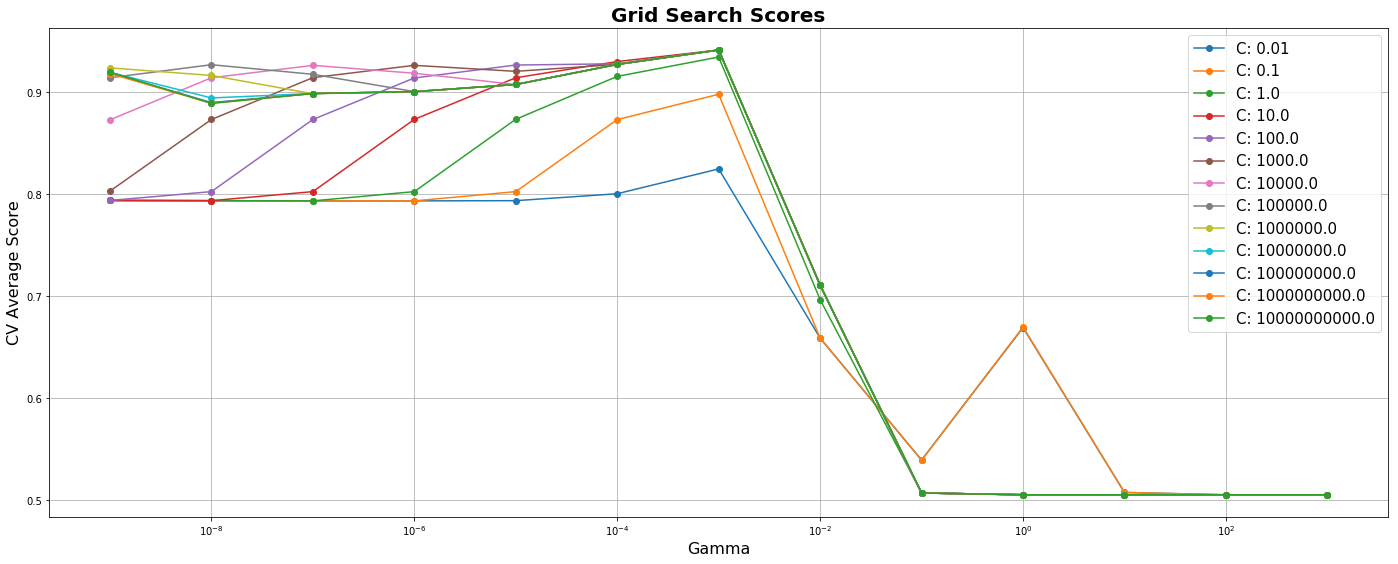

In [21]:
plot_grid_search(top_model.cv_results_,gamma_range,C_range,'Gamma','C')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


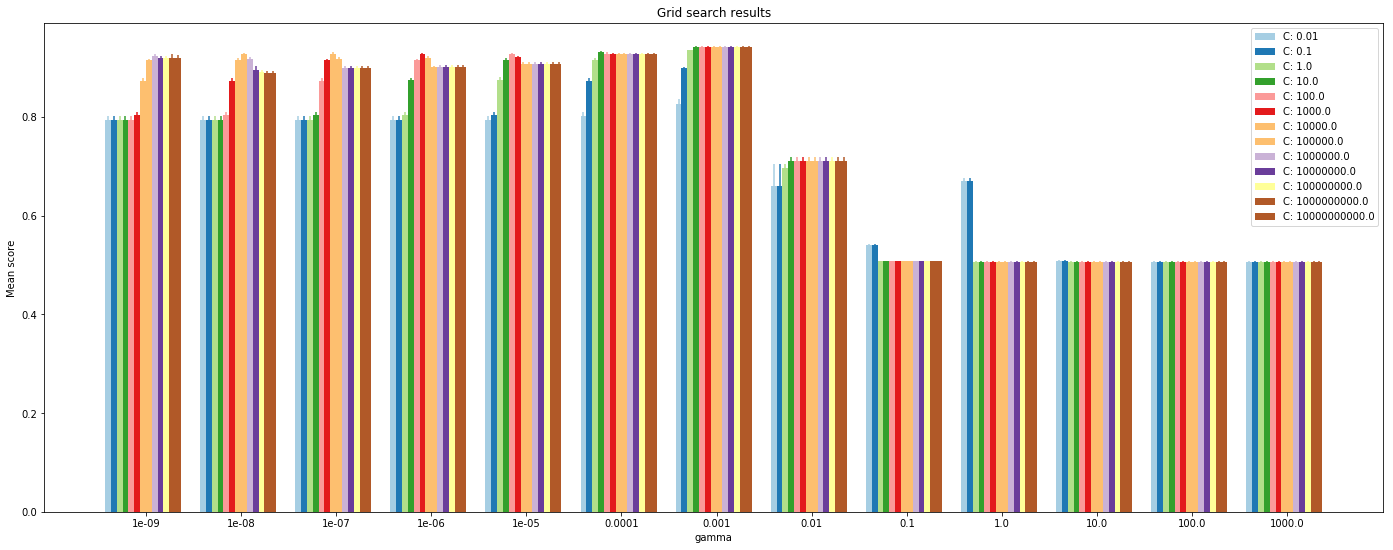

In [74]:
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


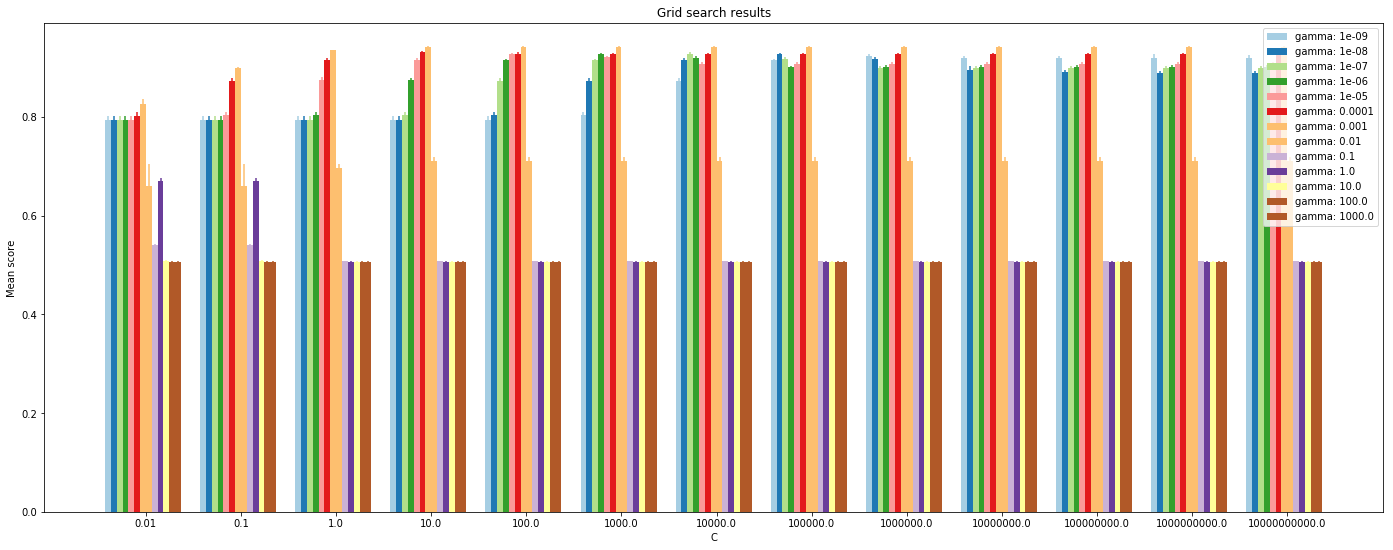

In [75]:
skplot.grid_search(top_model.grid_scores_, change='C', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

In [24]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
svm_model = svm.SVC(C=10.0,gamma=0.001)
train_sizes = np.linspace(.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(svm_model, resnet50features, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)

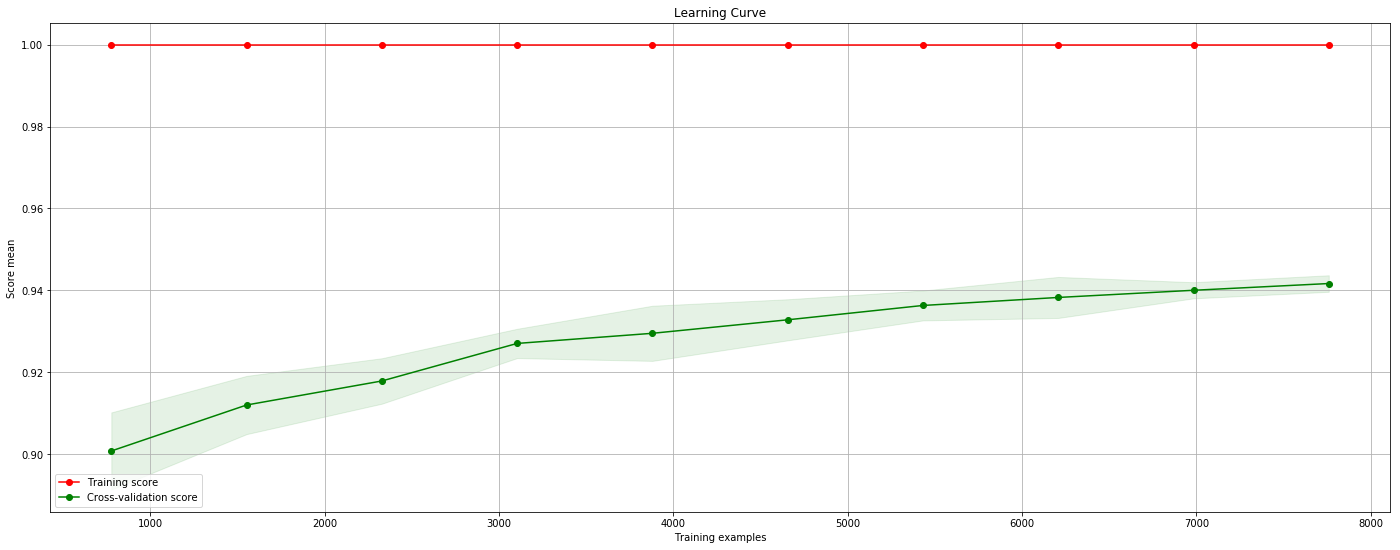

In [25]:
figure = plt.gcf()
figure.set_size_inches(24, 9)
skplot.learning_curve(train_scores, test_scores, train_sizes)
plt.show()